In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import sys
import os

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Naive

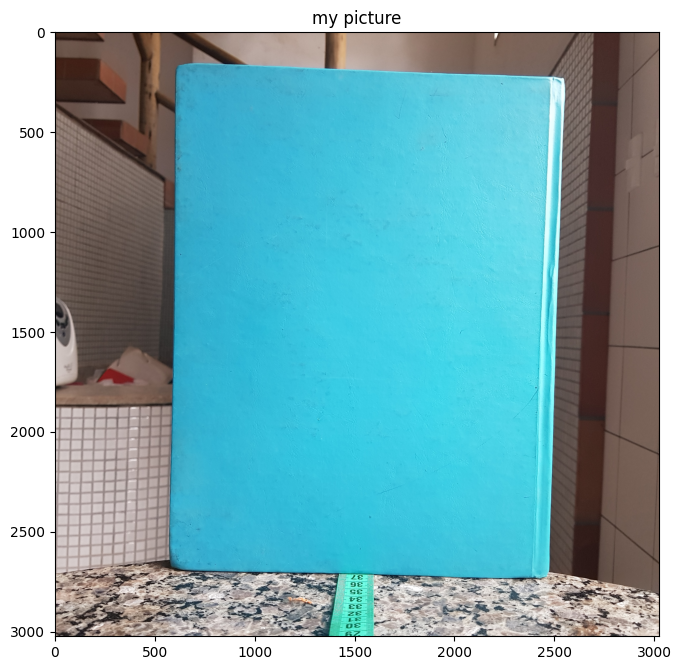

In [2]:
image = cv2.imread("Livro.jpg")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(gray)
plt.title('my picture')
plt.show()

The image above have:

    width=3021px
    heigth=3021px
   
 The book in the image have:
 
    width=1938px
    heigth=2542px

The real size of the book is:
    
    width=22.85cm
    height=28.4cm
    
And its center is located about 37cm from the camera position.

That being, we can aproximate:

    fx = 37*(1938/22.85)


In [3]:
fx = 37*(1938/22.85)
fx

3138.1181619256013

In [4]:
fy = 37*(2542/28.4)
fy

3311.760563380282

In [5]:
cx = 3021/2
cx

1510.5

In [6]:
cy = 3021/2
cy

1510.5

## Octave

Using the Octave Calibration Toolbox (https://github.com/nghiaho12/camera_calibration_toolbox_octave) we obtain:


In [7]:
octave1 = cv2.imread("octave1.png")
octave2 = cv2.imread("octave2.png")
octave3 = cv2.imread("octave3.png")
octave4 = cv2.imread("octave4.png")
octave5 = cv2.imread("octave5.png")

octave1_d = cv2.cvtColor(octave1, cv2.COLOR_BGR2RGB)
octave2_d = cv2.cvtColor(octave2, cv2.COLOR_BGR2RGB)
octave3_d = cv2.cvtColor(octave3, cv2.COLOR_BGR2RGB)
octave4_d = cv2.cvtColor(octave4, cv2.COLOR_BGR2RGB)
octave5_d = cv2.cvtColor(octave5, cv2.COLOR_BGR2RGB)


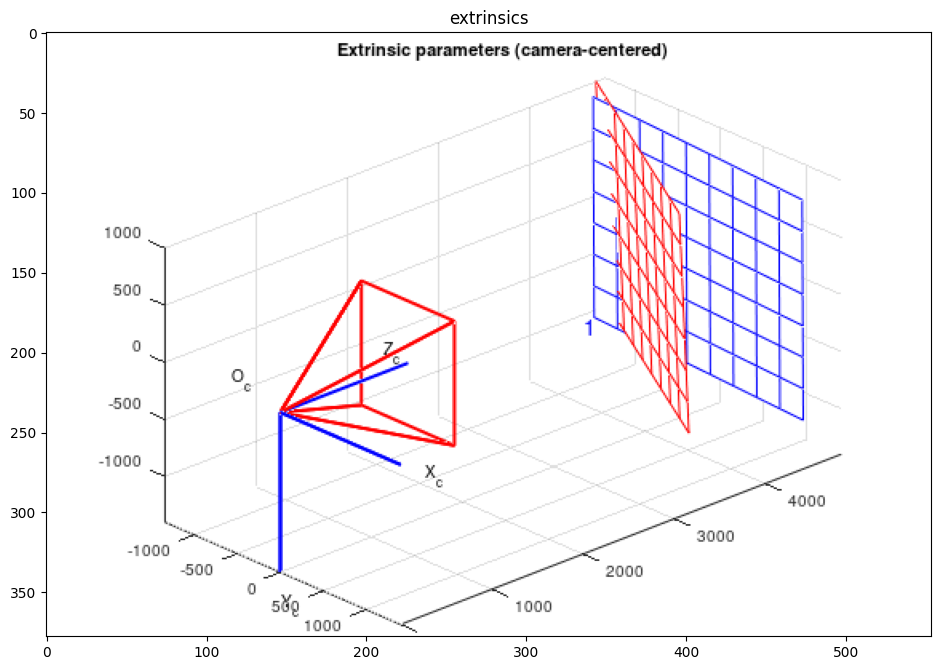

In [8]:
plt.imshow(octave1_d)
plt.title('extrinsics')
plt.show()

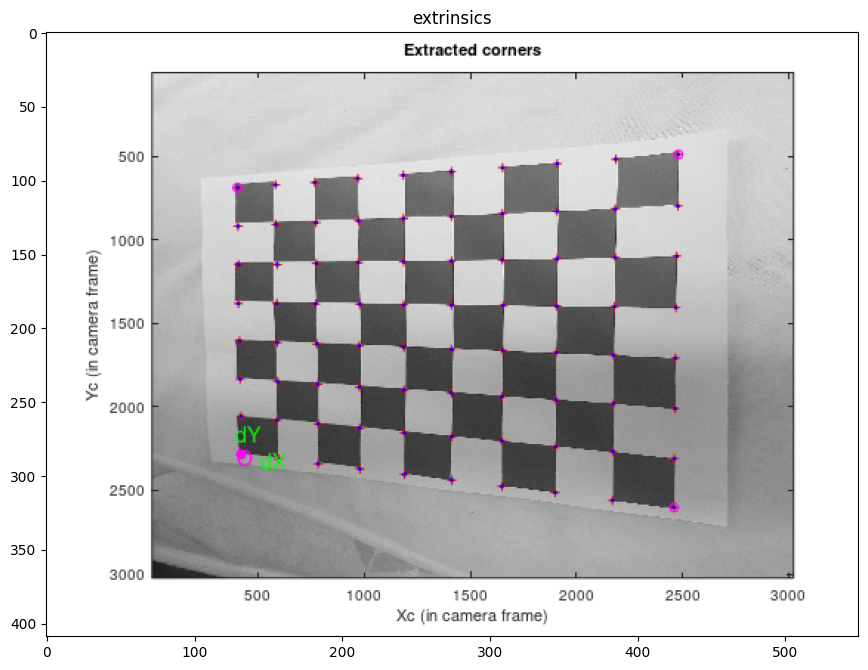

In [9]:
plt.imshow(octave2_d)
plt.title('extrinsics')
plt.show()

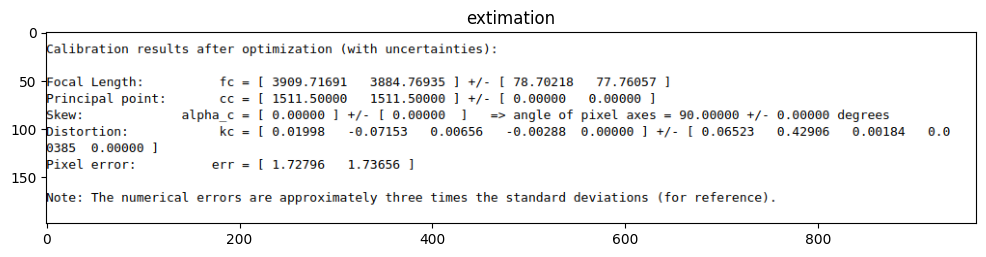

<Figure size 2000x2000 with 0 Axes>

In [10]:
plt.imshow(octave3_d)
plt.title('extimation')
plt.figure(figsize=(20, 20))
plt.show()

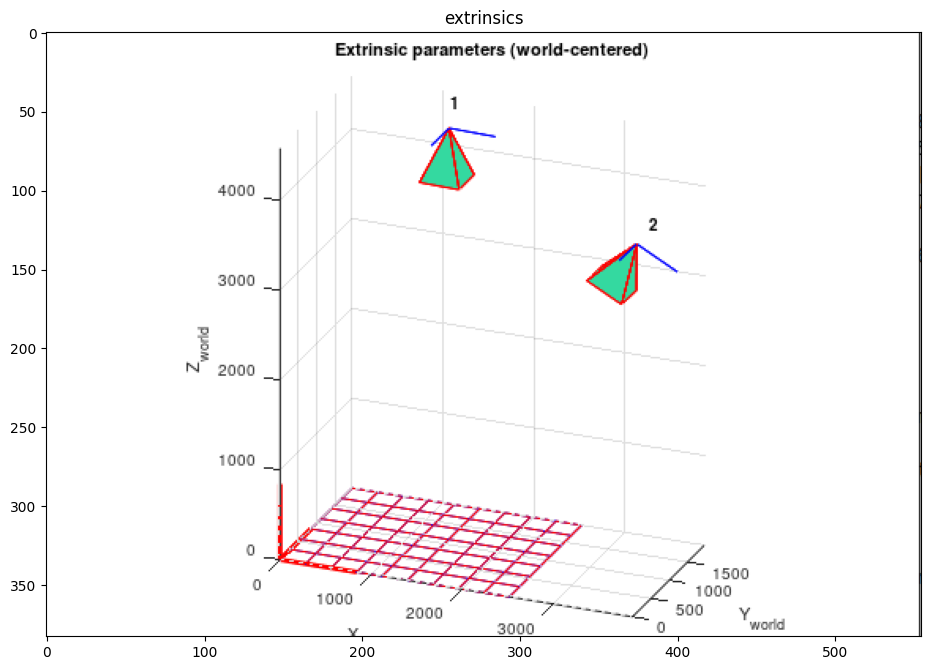

In [11]:
plt.imshow(octave4_d)
plt.title('extrinsics')
plt.show()

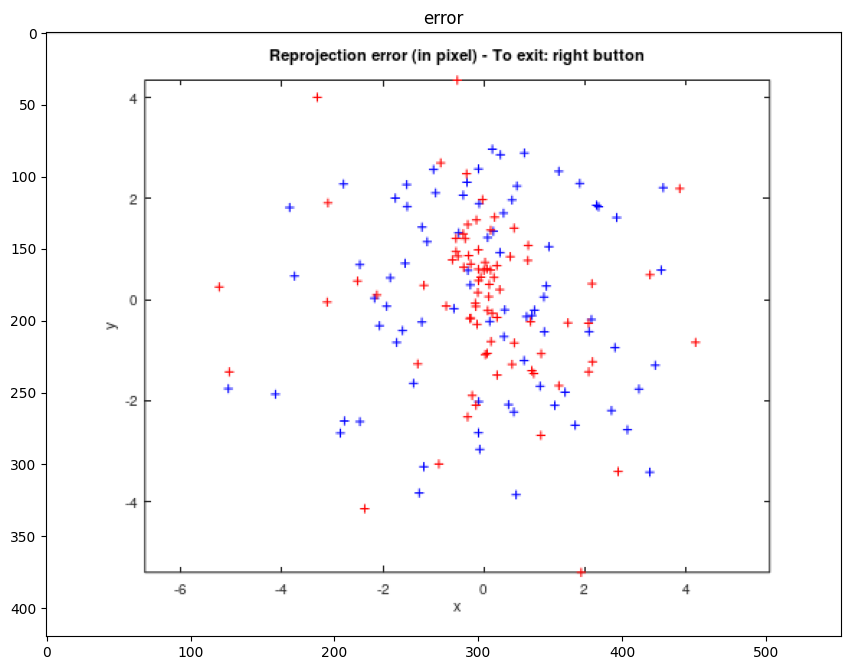

In [12]:
plt.imshow(octave5_d)
plt.title('error')
plt.show()

so we obtain fx = 3909 and fy = 3884 using Octave

## Python

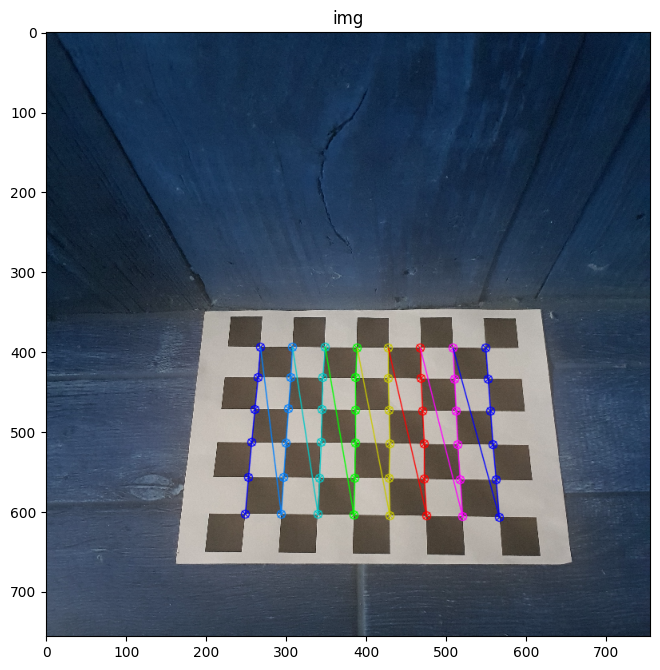

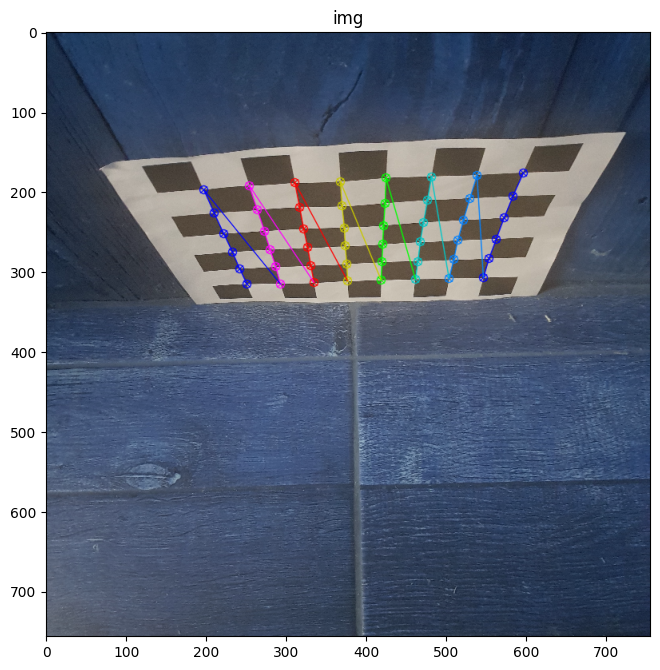

In [40]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []
images = ['image5.jpg', 'image6.jpg']

image_corners = []


for fname in images:
    img = cv2.imread(fname)
    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (6,8), None)
    if ret == True:
        image_corners.append(corners)
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (6,8), corners2, ret)
        plt.imshow(img)
        plt.title('img')
        plt.show()

In [41]:
x = []
y = []

for i in range(len(image_corners[0])):
    x = np.append(x, image_corners[0][i][0][0])
    y = np.append(y, image_corners[0][i][0][1])
for i in range(len(image_corners[1])):
    x = np.append(x, image_corners[1][i][0][0])
    y = np.append(y, image_corners[1][i][0][1])

points = [x, y]

The images are rotated about 90° of each other. We can combine the two images and the points of the chess board to obtain the points that will be used by the algorithm.

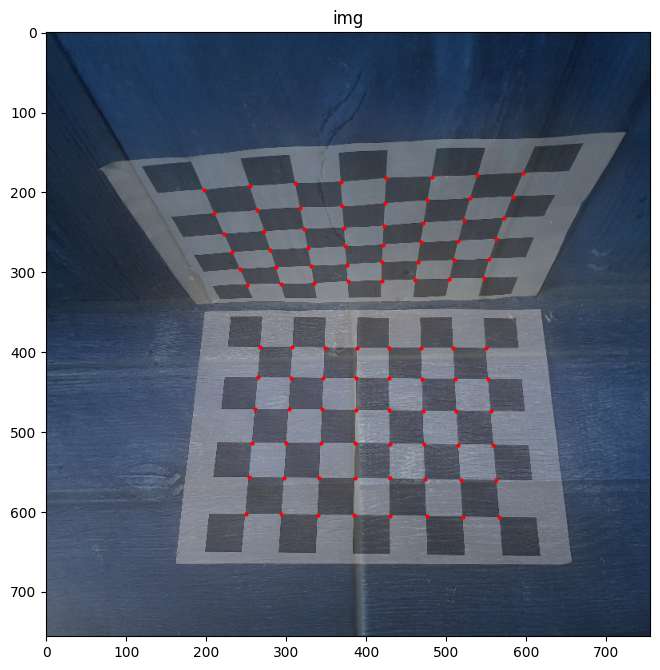

In [42]:
img6 = cv2.imread('image6.jpg')
scale_percent = 25
width = int(img6.shape[1] * scale_percent / 100)
height = int(img6.shape[0] * scale_percent / 100)
dim = (width, height)
img6 = cv2.resize(img6, dim, interpolation = cv2.INTER_NEAREST)

img5 = cv2.imread('image5.jpg')
scale_percent = 25
width = int(img5.shape[1] * scale_percent / 100)
height = int(img5.shape[0] * scale_percent / 100)
dim = (width, height)
img5 = cv2.resize(img5, dim, interpolation = cv2.INTER_NEAREST)

def blend(list_images):
    equal_fraction = 1.0 / (len(list_images))
    output = np.zeros_like(list_images[0])
    for img in list_images:
        output = output + img * equal_fraction
    output = output.astype(np.uint8)
    return output

list_images = [img6, img5]
img = blend(list_images)

plt.imshow(img)
plt.title('img')
plt.scatter(x=points[0], y=points[1], c='r', s=4)
plt.show()

The points are obtained by setting the chess board of the first image as the (1,1,0) plane, and the chess board of the second image as the (1,0,1) plane.

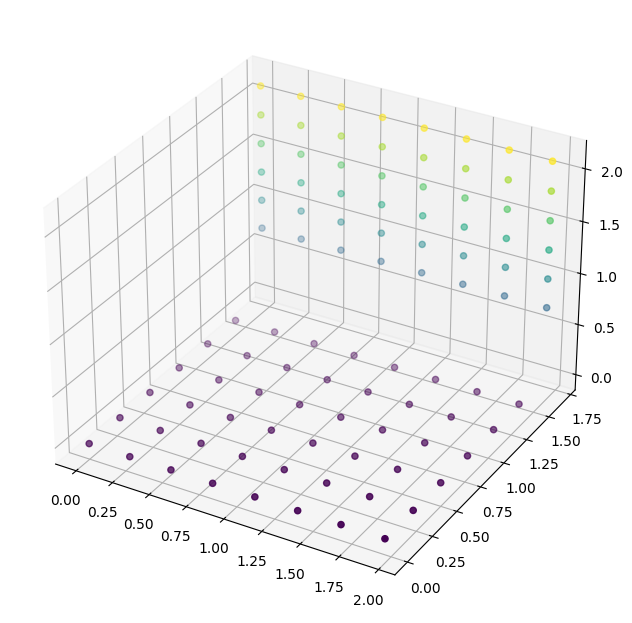

In [43]:
p = image_corners[0]

square_x_cm = 0.28
square_y_cm = 0.28

image_point = []
world_point = []

# Get the points of the first image in world coordinates by setting the z coordinate as 0
# and varying the coordinates in the x,y direction.
for i in range(8):
    for j in range(6):
        image_point.append(
            p[i*6 + j][0]
        )
        world_point.append([
            i*square_x_cm, # x
            j*square_y_cm, # y
            0.0            # z
        ])

        
p = image_corners[1]

# Get the points of the second image in world coordinates by setting the y coordinate as 6*2.80
# because the points in the second plane are shiffted approximately 6 squares in the z coordinate
# and varying the coordinates in the x,y direction.
for i in range(8):
    for j in range(6):
        image_point.append(
            p[i*6 + j][0]
        )
        world_point.append([
            7*square_x_cm - i*square_x_cm,                     # x
            6*square_y_cm,                                     # y
            0.15 + square_y_cm + 6*square_y_cm - j*square_y_cm # z
        ])

xdata = []
ydata = []
zdata = []

for i in range(96):
    xdata = np.append(xdata, world_point[i][0])
    ydata = np.append(ydata, world_point[i][1])
    zdata = np.append(zdata, world_point[i][2])

ax = plt.axes(projection='3d')

ax.scatter3D(xdata, ydata, zdata, c=zdata);

In [189]:
A = []

def build_line(image_points, world_points, i):
    return [
        image_points[i][0]*world_points[i][0],
        image_points[i][0]*world_points[i][1],
        image_points[i][0]*world_points[i][2],
        image_points[i][0],
        -1*image_points[i][1]*world_points[i][0],
        -1*image_points[i][1]*world_points[i][1],
        -1*image_points[i][1]*world_points[i][2],
        -1*image_points[i][1],
    ]

for i in range(96):
    A.append(build_line(image_point, world_point, i))

A = np.reshape(A,(96,8))

SVD = np.linalg.svd(A, full_matrices=True)
SVD[1]

array([1.10676684e+04, 4.45145196e+03, 2.85267082e+03, 1.71392022e+03,
       8.30897869e+02, 3.61115696e+02, 2.97429441e+02, 7.98337546e+00])

The smallest eigen value is in the 7'th row, so the vector that we are interested in is:

In [190]:
v = SVD[2][SVD[1].argmin()]

print("min eigen value =", min(SVD[1]))
print("corresponding eigen vector =", v)

min eigen value = 7.983375462342892
corresponding eigen vector = [-0.00698853 -0.16202727 -0.18580742  0.86300794  0.2220594   0.05278596
 -0.11649634  0.35878   ]


The gamma parameter, given by Trucco and Verri, is given by:

In [46]:
y = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
y

0.24662942157525194

The alpha*gamma parameter, given by Trucco and Verri, is given by:

In [47]:
ay = np.sqrt(v[4]**2 + v[5]**2 + v[6]**2)
ay

0.25625794407960917

And so we have the alpha(aspect ratio) parameter given by:

In [48]:
a = ay/y
a

1.0390404455513

The first two rows of the intrinsic matrix can by recovered by:

In [38]:
r = np.zeros((3,3))

r[1,0] = v[0]
r[1,1] = v[1]
r[1,2] = v[2]

Ty     = v[3]

r[0,0] = v[4]/a
r[0,1] = v[5]/a
r[0,2] = v[6]/a

Tx     = v[7]/a

r

array([[ 0.21371584,  0.0508026 , -0.11211916],
       [-0.00698853, -0.16202727, -0.18580742],
       [ 0.        ,  0.        ,  0.        ]])

The Tz and fx parameters of the third row can be approximated by:

In [191]:
def build_A_line(image_points, world_points, r, i):
    return [
        image_points[i][0], (r[0,0]*world_points[i][0] + r[0,1]*world_points[i][1] + r[0,2]*world_points[i][2] + Tx),
    ]

A = []
b = []

for i in range(96):
    A.append(build_A_line(image_point, world_point, r, i))

A = np.reshape(A,(96,2))

def build_b_line(image_points, world_points, r, i):
    return [
        -1*image_points[i][0]*(r[2,0]*world_points[i][0] + r[2,1]*world_points[i][1] + r[2,2]*world_points[i][2]),
    ]

for i in range(96):
    b.append(build_b_line(image_point, world_point, r, i))

((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)

array([[0.],
       [0.]])

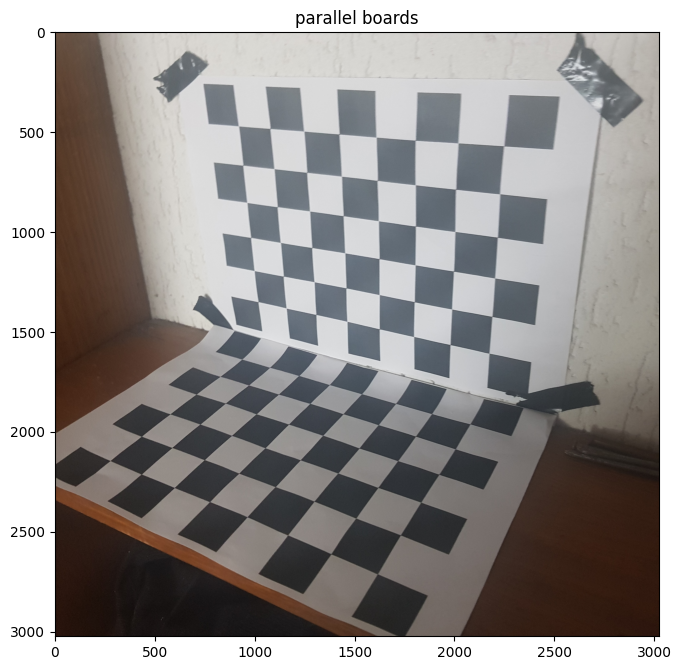

In [192]:
parallel_boards = cv2.imread("image7.jpg")
parallel_boards = cv2.cvtColor(parallel_boards, cv2.COLOR_BGR2RGB)
plt.imshow(parallel_boards)
plt.title('parallel boards')
plt.show()

The image points are:

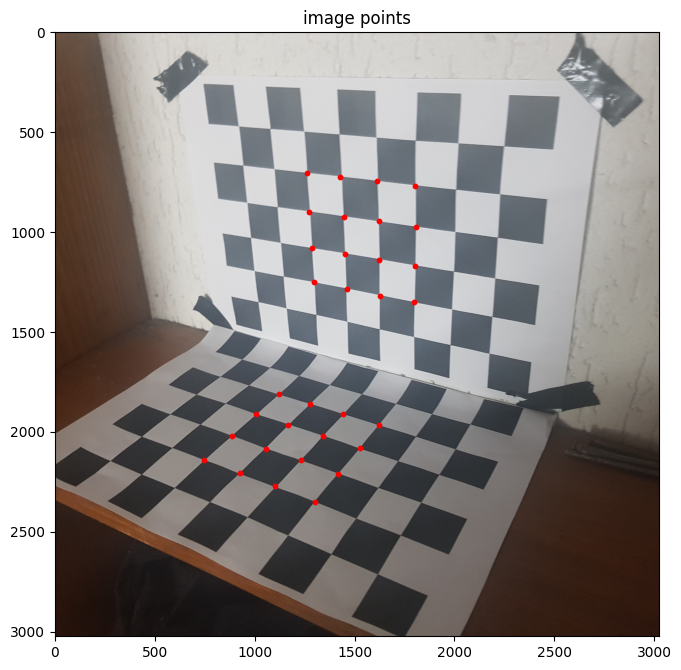

In [193]:
image_points = [
    [748, 2140],
    [884, 2020],
    [1008, 1912],
    [1120, 1812],
    
    [924, 2204],
    [1056, 2084],
    [1168, 1964],
    [1276, 1860],
    
    [1104, 2272],
    [1232, 2140],
    [1342, 2020],
    [1444, 1912],
    
    [1300, 2349],
    [1419, 2211],
    [1525, 2083],
    [1621, 1966],
    
    [1296, 1252],
    [1286, 1080],
    [1274, 898],
    [1262, 706],
    
    [1460, 1284],
    [1452, 1108],
    [1446, 922],
    [1428, 724],
    
    [1625, 1318],
    [1624, 1138],
    [1621, 946],
    [1614, 746],
    
    [1800, 1352],
    [1803, 1168],
    [1806, 974],
    [1805, 768],
]

x = []
y = []

for i in range(len(image_points)):
    x.append(image_points[i][0])
    y.append(image_points[i][1])

plt.imshow(parallel_boards)
plt.title('image points')
plt.scatter(x=x, y=y, c='r', s=10)
plt.show()

The world points, using the first point as the (0,0,0) and units in mm are:

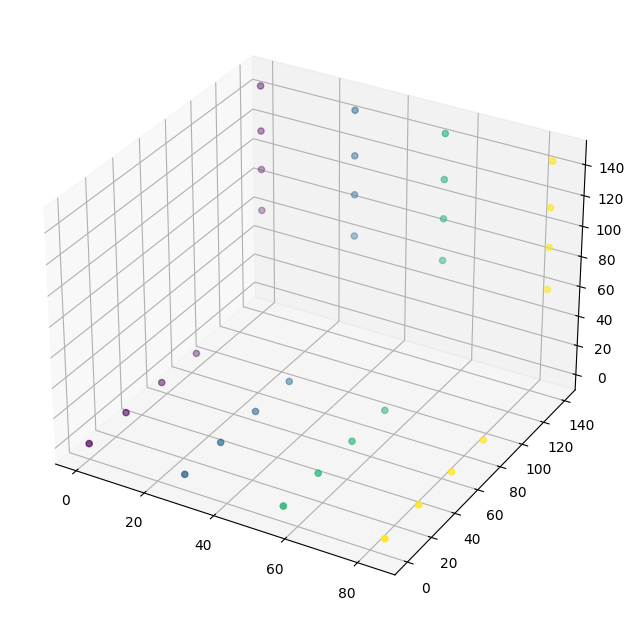

In [194]:
margin = 7

world_points = [
    [0, 0,  0],
    [0, 28, 0],
    [0, 56, 0],
    [0, 84, 0],
    
    [28, 0,  0],
    [28, 28, 0],
    [28, 56, 0],
    [28, 84, 0],
    
    [56, 0,  0],
    [56, 28, 0],
    [56, 56, 0],
    [56, 84, 0],
    
    [84, 0,  0],
    [84, 28, 0],
    [84, 56, 0],
    [84, 84, 0],
    
    [0, 140, 0  + 54 + margin],
    [0, 140, 28 + 54 + margin],
    [0, 140, 54 + 54 + margin],
    [0, 140, 84 + 54 + margin],
    
    [28, 140, 0  + 54 + margin],
    [28, 140, 28 + 54 + margin],
    [28, 140, 54 + 54 + margin],
    [28, 140, 84 + 54 + margin],    
 
    [54, 140, 0  + 54 + margin],
    [54, 140, 28 + 54 + margin],
    [54, 140, 54 + 54 + margin],
    [54, 140, 84 + 54 + margin],

    [84, 140, 0  + 54 + margin],
    [84, 140, 28 + 54 + margin],
    [84, 140, 54 + 54 + margin],
    [84, 140, 84 + 54 + margin],
]

x = []
y = []
z = []

for i in range(len(world_points)):
    world_points[i] = [world_points[i][0], world_points[i][1], world_points[i][2]]
    x.append(world_points[i][0])
    y.append(world_points[i][1])
    z.append(world_points[i][2])

ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z, c=x);

In [195]:
A = []

def build_line(image_points, world_points, i):
    return [
        image_points[i][0]*world_points[i][0],
        image_points[i][0]*world_points[i][1],
        image_points[i][0]*world_points[i][2],
        image_points[i][0],
        -1*image_points[i][1]*world_points[i][0],
        -1*image_points[i][1]*world_points[i][1],
        -1*image_points[i][1]*world_points[i][2],
        -1*image_points[i][1],
    ]

for i in range(len(image_points)):
    A.append(build_line(image_points, world_points, i))

SVD = np.linalg.svd(A, full_matrices=True)

In [196]:
v = SVD[2][SVD[1].argmin()]

min eigen value:

In [197]:
min(SVD[1])

21.962894235209138

corresponding eigen vector

In [198]:
v

array([-1.26663782e-04, -4.31845159e-04, -3.53728068e-03,  9.43094446e-01,
        2.17897154e-03,  2.69185466e-03, -2.99920859e-04,  3.32487694e-01])

The gamma parameter, given by Trucco and Verri, is given by:

In [199]:
y = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
y

0.0035657942450506293

The alpha\*gamma parameter, given by Trucco and Verri, is given by:

In [200]:
ay = np.sqrt(v[4]**2 + v[5]**2 + v[6]**2)
ay

0.0034761977784463077

The alpha(aspect ratio) parameter is given by:

In [201]:
a = ay/y
a

0.9748733492604957

The first two rows of the intrinsic matrix can by recovered by:

In [214]:
r = np.zeros((3,3))

r[1,0] = v[0]
r[1,1] = v[1]
r[1,2] = v[2]

Ty     = v[3]

r[0,0] = v[4]/a
r[0,1] = v[5]/a
r[0,2] = v[6]/a

Tx     = v[7]/a

l0 = [r[0,0], r[0,1], r[0,2]]
l1 = [r[1,0], r[1,1], r[1,2]]

l3 = np.cross(l0, l1)
r[2,0] = l3[0]
r[2,1] = l3[1]
r[2,2] = l3[2]

print(r)

print("Tx=",Tx,"Ty", Ty)

[[ 2.23513294e-03  2.76123525e-03 -3.07651101e-04]
 [-1.26663782e-04 -4.31845159e-04 -3.53728068e-03]
 [-9.90012176e-06  7.94526084e-06 -6.15482843e-07]]
Tx= 0.3410573225605134 Ty 0.9430944461063331


In [211]:
l0 = [r[0,0], r[0,1], r[0,2]]
l1 = [r[1,0], r[1,1], r[1,2]]

l3 = np.cross(l0, l1)
r[2,0] = l3[0]
r[2,1] = l3[1]
r[2,2] = l3[2]


The Tz and fx parameters of the third row can be approximated by:

In [215]:
def build_A_line(image_points, world_points, r, i):
    return [
        image_points[i][0], (r[0,0]*world_points[i][0] + r[0,1]*world_points[i][1] + r[0,2]*world_points[i][2] + Tx),
    ]

A = []
b = []

for i in range(len(image_points)):
    A.append(build_A_line(image_points, world_points, r, i))

A = np.reshape(A,(len(image_points),2))

def build_b_line(image_points, world_points, r, i):
    return [
        -1*image_points[i][0]*(r[2,0]*world_points[i][0] + r[2,1]*world_points[i][1] + r[2,2]*world_points[i][2]),
    ]

for i in range(len(image_points)):
    b.append(build_b_line(image_points, world_points, r, i))

C = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)

print("Tz =", C[0])
print("fx =", C[1])

Tz = [0.00646282]
fx = [-13.76815533]
